In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from babel.numbers import get_currency_symbol
import humanize

# Data For Good - Tax Observatory Dataviz

Visualizations for the EU Tax Observatory based on the [EU Tax Obs - Dataviz - Viz](https://docs.google.com/document/d/1q_7x8NrEWNsak9LSE3TxIiSphhVcqWqn6YeG1kQNQTk/edit#heading=h.97g77izer615) Google Docs.

## Table of contents
* [Initialization](#initialization)
* [#12 - available reports by company](#12---available-reports-by-company)
* [#13 - company key financials kpis](#13---company-key-financials-kpis)
* [#14 - company top jurisdictions for revenue](#14---company-top-jurisdictions-for-revenue)

## Initialization

In [235]:
# Import dataset in a DataFrame
df = pd.read_csv('data_final_dataviz.csv', sep=',')

In the website it will be possible to select a specific company. To work on the viz creation, we simulate the selection by picking a random company but also a random year.

In [236]:
# Select a random company and a random year
def pick_random_company_and_year() -> tuple:
    company = np.random.choice(df['mnc'].unique())
    print(f'Selected company : {company}.')

    year = np.random.choice(df.loc[df['mnc'] == company, 'year'].unique())
    print(f'Selected year : {year}.')

    return company, year

In [237]:
company, year = pick_random_company_and_year()
# company, year = 'SHELL', 2020

Selected company : LEONARDO.
Selected year : 2021.


## #12 - available reports by company

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|tbd (goal is on company page, to show reports tracked, so could be just a table showing year available for a company)|-||`company explo` need a filter by company||

In [238]:
def compute_company_available_reports(
        df: pd.DataFrame=df, company: str=company) -> dict:
    
    available_years = df.loc[df['mnc'] == company, 'year'].unique()
    n_reports = len(available_years)

    # Convert type of items from 'int' to 'str' in available years list
    years_string_list = [str(year) for year in available_years]
    
    if len(years_string_list) == 1:
        years_string = years_string_list[0]
    elif len(years_string_list) > 1:
        years_string = ', '.join(years_string_list[:-1])
        years_string += ' and ' + years_string_list[-1]

    data = {
        'Company': company,
        'Reports': n_reports,
        'Fiscal year(s) available': years_string
    }

    return data


data =compute_company_available_reports()
pd.DataFrame.from_dict(data=data, orient='index').style.hide(axis='columns')

Company,LEONARDO
Reports,4
Fiscal year(s) available,"2018, 2019, 2020 and 2021"


## #13 - company key financials kpis

**kpis** : hq country, total revenue, total unrelated party revenues, total related party revenues, pre-tax profits, taxes paid, employees.

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|raw figure for each, or table with indicator name in col A, value in col B|hq country : -<br><br>metrics : sum (metric) by year by mnc|**giulia : keep all values, even negative values**|`company explo` need a filter by company||

In [239]:
def compute_company_key_financials_kpis(
        df: pd.DataFrame=df, company: str=company, year: int=None) -> dict:
    
    # List financial kpis
    kpis_list = ['total_revenues', 'unrelated_revenues', 'related_revenues', 
                 'profit_before_tax', 'tax_paid', 'employees']
    
    years = df.loc[df['mnc'] == company, 'year'].unique()
    currency = df['currency'].unique()[0]
    currency_symbol = get_currency_symbol(currency, locale='en_US')

    if not year or year not in years:
        df = (df.loc[df['mnc'] == company]
            .groupby(['year', 'upe_name'], as_index=False)[kpis_list]
            .sum()
        )
    else:
        df = (df.loc[(df['mnc'] == company) & (df['year'] == year)]
              .groupby(['year', 'upe_name'], as_index=False)[kpis_list]
              .sum())

    df = df.set_index('year')

    for column in df.columns:
        if column not in ['employees', 'upe_name']:
            df[column] = df[column].apply(
                lambda x: humanize.intword(x) if isinstance(x, (int, float)) else x)
            df[column] = currency_symbol + ' ' + df[column]
        elif column == 'employees':
            df[column] = df[column].astype(int)

    df = df.rename(columns={'upe_name': 'headquarter'})
    df.columns = df.columns.str.replace('_', ' ').str.capitalize()

    data = df.to_dict(orient='index')

    return data

In [240]:
data = compute_company_key_financials_kpis()
pd.DataFrame.from_dict(data)

,2018,2019,2020,2021
Headquarter,Italy,Italy,Italy,Italy
Total revenues,€ 14.8 billion,€ 16.7 billion,€ 16.0 billion,€ 16.9 billion
Unrelated revenues,€ 13.2 billion,€ 14.9 billion,€ 14.4 billion,€ 15.3 billion
Related revenues,€ 1.6 billion,€ 1.8 billion,€ 1.6 billion,€ 1.5 billion
Profit before tax,€ 732.0 million,€ 908.0 million,€ 278.0 million,€ 634.0 million
Tax paid,€ 30.0 million,€ 70.0 million,€ 99.0 million,€ 53.0 million
Employees,46489,50049,50186,50413


## #14 - company top jurisdictions for revenue

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart showing % total revenue for top 9 jurisdictions + rest as “OTHERS”|sum(revenue) by company x hq country x year, display top 9 and group remaining countries||`company explo` need a filter by company||

In [241]:
def compute_top_jurisdictions_revenue(
        df: pd.DataFrame=df, company: str=company, year:int=year) -> dict:
    
    df = df.loc[(df['mnc'] == company) & (df['year'] == year), ['jur_name', 'total_revenues']]
    df = df.fillna(0)
    df = df.sort_values(by='total_revenues', ascending=False)

    top = df[:9].copy()

    others = df[9:]['total_revenues'].sum()
    top.loc[9] = ['Others', others]

    top['total_revenues_%'] = top['total_revenues'] / top['total_revenues'].sum() * 100

    top = top.sort_values(by='total_revenues_%').reset_index(drop=True)

    data = top.to_dict()
    
    return data

In [242]:
pd.DataFrame(compute_top_jurisdictions_revenue())

,jur_name,total_revenues,total_revenues_%
0,Others,0.000000e+00,0.000000
1,Poland,2.290000e+08,1.357842
2,Other,4.770000e+08,2.828343
3,United Kingdom,2.409000e+09,14.284020
4,United States of America,3.353000e+09,19.881411
5,Italy,1.039700e+10,61.648384


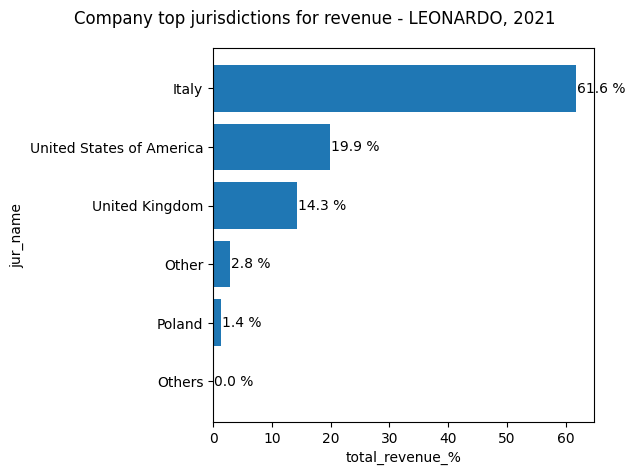

In [243]:
def plot_jurisdictions_top_revenue():

    top = pd.DataFrame(compute_top_jurisdictions_revenue())

    fig, ax = plt.subplots()
    bar = ax.barh(y=top['jur_name'], width=top['total_revenues_%'])

    ax.bar_label(bar, fmt='{:.1f} %', padding=1)

    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('total_revenue_%')
    ax.set_ylabel('jur_name')

    fig.suptitle(f'Company top jurisdictions for revenue - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_jurisdictions_top_revenue()

## #15 - company’s % pre-tax profit and % employees by jurisdiction

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart with one bar for % pre tax profit, the other for % employees, in different colors rank by % pre-tax profit descending|for a company : filter (profit >0) profits by JUR / total profit vs employees by JUR / total employees|**giulia : keep only positive values**|`company explo` need a filter by company||

In [244]:
def compute_pretax_profit_and_employees_rank(
        df: pd.DataFrame=df, company: str=company, year: int=year) -> dict:
    
    df = df.loc[
        (df['mnc'] == company) & (df['year'] == year) & (df['profit_before_tax'] > 0), 
        ['jur_name', 'profit_before_tax', 'employees']
    ]

    df = df.fillna(0)
    df = df.sort_values(by='profit_before_tax').reset_index(drop=True)

    df['profit_before_tax_%'] = df['profit_before_tax'] / df['profit_before_tax'].sum() * 100
    df['employees_%'] = df['employees'] / df['employees'].sum() * 100

    data = df.to_dict()

    return data

In [245]:
pd.DataFrame(compute_pretax_profit_and_employees_rank())

,jur_name,profit_before_tax,employees,profit_before_tax_%,employees_%
0,Other,12000000.0,1753.0,1.892744,3.477278
1,Poland,30000000.0,2548.0,4.731861,5.054252
2,United States of America,163000000.0,7253.0,25.709779,14.387162
3,Italy,166000000.0,31521.0,26.182965,62.525539
4,United Kingdom,263000000.0,7338.0,41.482650,14.555769


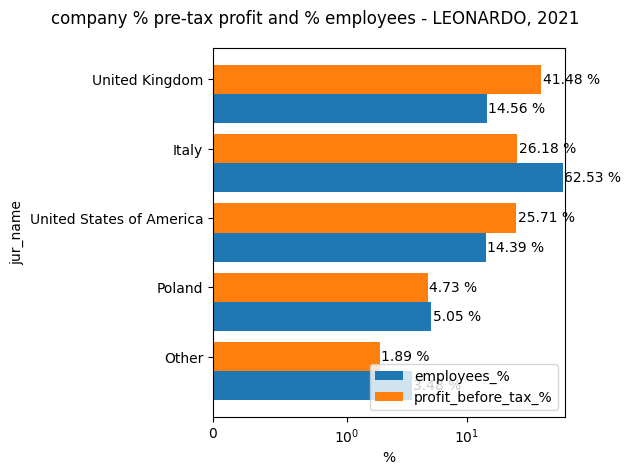

In [246]:
def plot_pretax_profit_and_employees_rank():

    rank = pd.DataFrame(compute_pretax_profit_and_employees_rank())

    jurisdictions = rank['jur_name'].values
    bar_width = 0.42
    bar_offsets = [-bar_width, 0, bar_width]

    fig_height = max(4.8, (0.48*len(jurisdictions)))
    fig, ax = plt.subplots(figsize=(6.4, fig_height))

    for i, (column, values) in enumerate(rank[['employees_%', 'profit_before_tax_%']].items()):
        bar_positions = []
        for j in range(len(jurisdictions)):
            bar_positions.append(j + bar_offsets[i])
        bars = ax.barh(bar_positions, values, height=bar_width, label=column)
        ax.bar_label(bars, fmt='{:.2f} %', padding=1)

    ax.set_xlabel('%')
    ax.set_yticks(range(len(jurisdictions)))
    ax.set_yticklabels(jurisdictions)
    ax.set_ylabel('jur_name')
    ax.set_xscale('symlog', linthresh=1)
    ax.legend(loc='lower right')
       
    fig.suptitle(f'company % pre-tax profit and % employees - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_pretax_profit_and_employees_rank()